In [99]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import copy
from tqdm import tqdm

# Neural stuff

In [100]:
sigm = lambda x: 1/(1+np.exp(-x))

In [101]:
class Layer:
    
    
    def __init__(self,NC,NN,ActFun,rate=0.01): # Jugar con la tasa de mutacion
        
        self.NC = NC
        self.NN = NN
        self.ActFunc = ActFun
        self.rate = rate
        
        self.W = np.random.uniform( -10.,10.,(self.NC,self.NN) )
        self.b = np.random.uniform( -10.,10.,(1,self.NN) )
        
    def Activation(self,x):
        z = np.dot(x,self.W) + self.b
        return self.ActFunc( z )[0]
    
    def Mutate(self):
    
        #self.W += np.random.normal( loc=0., scale=self.rate, size=(self.NC,self.NN))
        #self.b += np.random.normal( loc=0., scale=self.rate, size=(1,self.NN))
        
        self.W += np.random.uniform( -self.rate, self.rate, size=(self.NC,self.NN))
        self.b += np.random.uniform( -self.rate, self.rate, size=(1,self.NN))
    def get_param(self):
        self.W
        self.b
        return [self.W, self.b]

In [102]:
def GetBrain():
    l0 = Layer(1,5,sigm)
    l1 = Layer(5,1,sigm)
    #l2 = Layer(2,1,sigm)
    Brain = [l0,l1]
    return Brain    

# Estructura del individuo

In [103]:
class Robot:
    
    def __init__(self, dt, Layers, Id=0):
        
        self.Id = Id
        self.dt = dt
        
        
        self.r = np.random.uniform([0.,0.])
        theta = 0.
        self.v = np.array([1.*np.cos(theta),1.*np.sin(theta)])

        
        # Capacidad o aptitud del individuo
        self.Fitness = np.inf
        self.Steps = 0

        # Brain
        self.Layers = Layers
        
    def GetR(self):
        return self.r
    
    def Evolution(self):
       
        
        self.r += self.v*self.dt # Euler integration (Metodos 2)


        if -1 <= self.r[0] <= 1:
            self.Steps += 1

        
    def Reset(self):
        self.Steps = 1.
        self.r = np.array([0.,0.])
        self.Fitness = np.inf    
        
    
    def SetFitness(self):
        
        self.Fitness = 1/(self.Steps)  
        
        
    def BrainActivation(self,x,threshold=0.7): 

        for i in range(len(self.Layers)):         
            if i == 0:
                output = self.Layers[i].Activation(x)
            else:
                output = self.Layers[i].Activation(output)
        
        self.Activation = np.round(output,4)
    

        if self.Activation[0] > threshold:
            self.v = -self.v
            self.Steps*=0.9
    
        return self.Activation
    
    
    def Mutate(self):
        for i in range(len(self.Layers)):
            self.Layers[i].Mutate()
    

    def GetBrain(self):
        return self.Layers

In [104]:
def GetRobots(N):
    
    Robots = []
    
    for i in range(N):
        
        Brain = GetBrain()
        r = Robot(dt,Brain,Id=i)
        Robots.append(r)
        
    return Robots

In [105]:
dt = 0.1
t = np.arange(0.,5.,dt)
Robots = GetRobots(200)

In [106]:
def GetPlot():
    
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(1,2,1)
    ax1 = fig.add_subplot(1,2,2)
    
    ax.set_xlim(-1.,1.)
    ax.set_ylim(-1.,1.)
 
    return ax,ax1

# Time evolution

In [107]:
def TimeEvolution(Robots,e,Plot=True):
    
  
    for it in range(t.shape[0]):
        
        if Plot:
        
            clear_output(wait=True)
        
            ax,ax1 = GetPlot()
            ax1.set_ylim(0.,1.)
        
            ax.set_title('t = {:.3f}'.format(t[it]))
        
        Activation = np.zeros(len(Robots))
        
        for i,p in enumerate(Robots):
            p.Evolution()
         
            # Activacion cerebral
            Act = p.BrainActivation(p.GetR()[0])
            Activation[i] = Act
            # Region donde aumentamos los pasos para el fitness
            
                
            if Plot and i < 5: # Solo pintamos los primeros 5, por tiempo de computo
                ax.scatter(p.r[0],p.r[1],label='Id: {}, Steps: {:.0f}'.format(p.Id,p.Steps))
                ax.quiver(p.r[0],p.r[1],p.v[0],p.v[1])
                
        # Pintamos la activaciones de los primeros 5
        
        if Plot:
            ax1.plot(np.arange(0,len(Robots[:5]),1),Activation[:5],marker='o',color='b',label='Activation')
            ax1.axhline(y=0.7,color='r')
        
        if Plot:
        
            ax.legend(loc=0)  
            ax1.legend(loc=0)
            plt.show()
            time.sleep(0.001)

# Algoritmo evolutivo

In [108]:
# Definimos la rutina de entrenamiento
def Genetic(Robots, epochs = 200, Plot = True, Plottime=False):
    
    # Porcentaje de robots elegidos en cada epoch
    N = int(0.7*len(Robots))
    
    FitVector = np.array([])
    
    
    x = np.linspace(-1,1,20)
    Act = np.zeros_like(x)
    
    for e in range(int(epochs)):
        
        # Reiniciamos y mutamos los pesos
        
        for p in Robots:
            p.Reset() 
            p.Mutate()
            
        # Evolucionamos
        TimeEvolution(Robots,e,Plottime) # Apagar dibujar la evolución para entrenar
        
        # Actualizamos fitness de cada robot
        for i,p in enumerate(Robots):
            p.SetFitness()
        
        # Aca va toda la rutina de ordenar los bots del más apto al menos apto
        scores = [(p.Fitness,p) for p in Robots]
        scores.sort(key = lambda x: x[0], reverse = False)
        
        Temp = [r[1] for i,r in enumerate(scores) if i < N]

         # Copiado profundo
        for i,r in enumerate(Robots):
            j = i%N
            Robots[i] = copy.deepcopy(Temp[j])
        # Guardamos el mejor fitness y el mejor robot
        best_fitness = scores[0][0]
        best_bot = scores[0][1]
        
        FitVector = np.append(FitVector,best_fitness)
        
        for i in range(len(x)):
            Act[i] = best_bot.BrainActivation(x[i])
        
        clear_output(wait=True)
        
        print('Epoch:', e)
                
        # Last fitness
        print('Last Fitness:', FitVector[-1])
        
        OcultoW=best_bot.Layers[0].W
        Ocultob=best_bot.Layers[0].b
        print(OcultoW)
        print(Ocultob)
        
        OutputW=best_bot.Layers[1].W
        Outputb=best_bot.Layers[1].b
        print(OutputW)
        print(Outputb)
        
        if Plot:
            
            ax,ax1 = GetPlot()
            ax.plot(x,Act,color='k')
            ax.set_ylim(0.,1)
            ax.axhline(y=0.7,ls='--',color='r',label='Threshold')
            
            ax1.set_title('Fitness')
            ax1.plot(FitVector)
        
            ax.legend(loc=0)
            
            plt.show()
            
            time.sleep(0.01)
        
        
    
    return best_bot, FitVector, OcultoW, Ocultob, OutputW, Outputb

Epoch: 199
Last Fitness: 0.02248100355199856
[[-6.35666048  5.60180362  1.96629356 -4.30658775 -3.83544688]]
[[ 8.68750189  6.099523   -3.4825894   2.35345966 -2.62777369]]
[[ 6.38375417]
 [-2.66977917]
 [-0.41794273]
 [-7.60304942]
 [ 9.71103144]]
[[-0.39980793]]


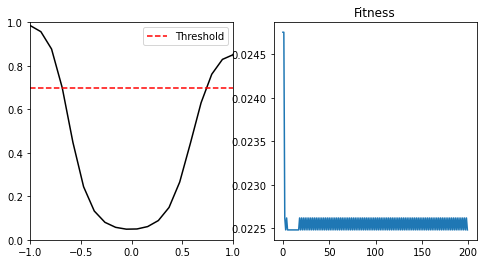

In [109]:
Robots = GetRobots(200)
Best, FitVector, OcultoW, Ocultob, OutputW, Outputb= Genetic(Robots,Plot=True,Plottime=False) # Apagar Plottime para el entrenamiento

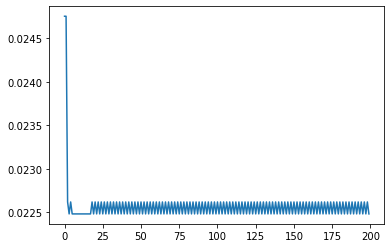

In [110]:
plt.plot(FitVector)

In [111]:
dt = 0.1
t = np.arange(0.,10.,dt)
Best.Reset()

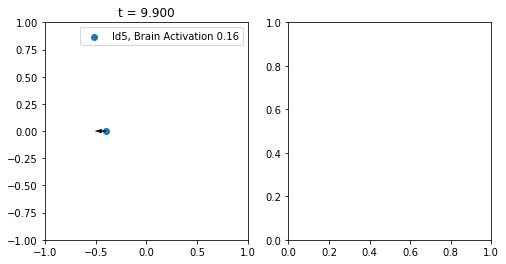

In [113]:
for it in range(t.shape[0]):
    clear_output(wait=True)

    Best.Evolution()

    A=Best.BrainActivation(Best.GetR()[0])

    ax,_=GetPlot()
    ax.set_title('t = {:.3f}'.format(t[it]))

    ax.scatter(Best.r[0],Best.r[1],label='Id{}, Brain Activation {:.2f}'.format(Best.Id,A[0]))
    ax.quiver(Best.r[0],Best.r[1],Best.v[0],Best.v[1])

    ax.legend()
    plt.show()

    time.sleep(0.01)

Resultados aceptados

W_0i=[[-6.35666048  5.60180362  1.96629356 -4.30658775 -3.83544688]]
b_0i=[[ 8.68750189  6.099523   -3.4825894   2.35345966 -2.62777369]]

W_10=[  
[ 6.38375417]

[-2.66977917]

[-0.41794273]

[-7.60304942]

[ 9.71103144]]

b_10=[[-0.39980793]]